# 01. EDA: Hipóteses e Comportamento
# 
**Objetivo:** Não é apenas visualizar distribuições, mas responder perguntas de negócio e validar a viabilidade da segmentação.

**Perguntas Chave:**
1. Quem são os clientes "ruído" (inativos) que devem ser removidos?
2. Existe o perfil "Tombo Recente" (pagava bem e parou)?
3. Existe o perfil "Crônico" (sempre atrasa)?
4. Qual a correlação entre uso de limite e inadimplência real?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from data_loader import load_raw_data

In [2]:
# Adiciona a pasta src ao path para o Python encontrar os módulos
# (O '..' sobe um nível para sair da pasta notebooks)
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from data_loader import load_raw_data
from features import process_pipeline

# Configurações visuais
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 50)

###  Passo 1: Limpeza de Ruído

In [3]:
# 1. Carga
file_path = os.path.join('..', 'data', 'raw', 'credit_card_clients.xls') # Ajuste se necessário
df = load_raw_data(file_path)

Tentando carregar: ..\data\raw\credit_card_clients.xls
✅ Arquivo detectado como Excel (.xls) e carregado com sucesso.


In [4]:
# Colunas de pagamento
pay_cols = [c for c in df.columns if 'status_pag_' in c]
bill_cols = [c for c in df.columns if 'bill_amt' in c]

In [5]:
# Filtro 1: Clientes "Fantasmas" (Status -2 ou 0 uso em todos os meses)
# Regra: Se a soma dos status for -12 (6 meses * -2) E a soma das faturas for perto de 0
filter_inativos = (df[pay_cols].sum(axis=1) == -12) & (df[bill_cols].sum(axis=1) == 0)

print(f"Total de Clientes: {len(df)}")
print(f"Clientes Inativos (Ruído): {filter_inativos.sum()} ({filter_inativos.mean():.2%})")

Total de Clientes: 30000
Clientes Inativos (Ruído): 325 (1.08%)


In [6]:
# DECISÃO: Removemos esses clientes do dataset de análise
df_clean = df[~filter_inativos].copy()
print(f"Dataset Ativo: {len(df_clean)}")

Dataset Ativo: 29675


### Passo 2: Proto-Features de Negócio

In [7]:
# 1. "Pagamento vs Fatura" (O quanto ele consegue pagar?)
# Se bill é 0, assumimos razão 1 (sem dívida).
df_clean['fatura_total_6m'] = df_clean[bill_cols].sum(axis=1)
df_clean['pagamento_total_6m'] = df_clean[[c for c in df.columns if 'pay_amt' in c]].sum(axis=1)
df_clean['razao_pagamento'] = np.where(
    df_clean['fatura_total_6m'] > 0,
    df_clean['pagamento_total_6m'] / df_clean['fatura_total_6m'],
    1.0
)
# Trava em 1.0 (se pagou mais que a fatura, é 100% pago)
df_clean['razao_pagamento'] = df_clean['razao_pagamento'].clip(upper=1.0)

In [8]:
# 2. "Uso do Limite" (Desespero)
df_clean['uso_limite'] = df_clean['bill_amt1'] / df_clean['limite_credito']

In [9]:
# 3. "Intensidade do Atraso" (Soma de meses atrasados, ignorando negativos)
df_clean['intensidade_atraso'] = df_clean[pay_cols].applymap(lambda x: x if x > 0 else 0).sum(axis=1)

print("✅ Proto-features geradas.")

✅ Proto-features geradas.


C:\Users\viras\AppData\Local\Temp\ipykernel_12796\716320801.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_clean['intensidade_atraso'] = df_clean[pay_cols].applymap(lambda x: x if x > 0 else 0).sum(axis=1)


### Passo 3: Respondendo as perguntas

#### P1: Quem nunca atrasou, mas atrasou agora? (O "Slipping Payer")
*Business Value:* Esse é o cliente que recuperamos com lembrete amigável. Ameaçar ele gera churn.

📉 Clientes com 'Tombo Recente': 2726
Representam 9.2% da base ativa.


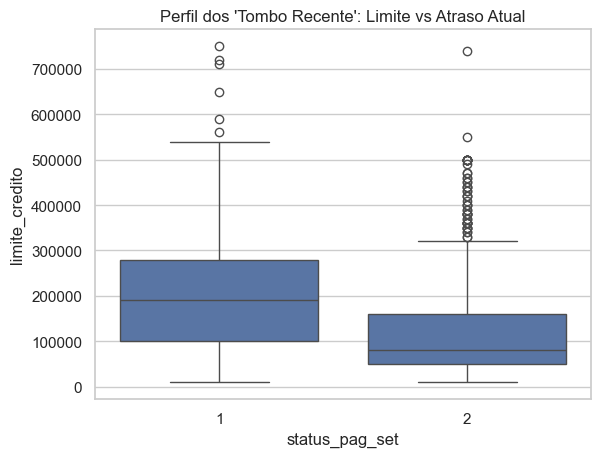

👉 São clientes VIPs em crise temporária. Abordagem: Conciliadora.


In [10]:
# Lógica: Mês atual (Set) > 0, mas média dos anteriores <= 0
mask_tombo_recente = (df_clean['status_pag_set'] > 0) & (df_clean[['status_pag_ago', 'status_pag_jul']].max(axis=1) <= 0)

print(f"📉 Clientes com 'Tombo Recente': {mask_tombo_recente.sum()}")
print(f"Representam {mask_tombo_recente.mean():.1%} da base ativa.")

# Validação visual desse grupo
sns.boxplot(data=df_clean[mask_tombo_recente], x='status_pag_set', y='limite_credito')
plt.title("Perfil dos 'Tombo Recente': Limite vs Atraso Atual")
plt.show()
print("👉 São clientes VIPs em crise temporária. Abordagem: Conciliadora.")

#### P2: Quem paga pouco mesmo com limite alto? (O "Risco Oculto")
*Business Value:* O cliente parece rico (limite alto), mas está alavancado.

⚠️ Clientes 'Alto Limite / Baixo Pagamento': 3867


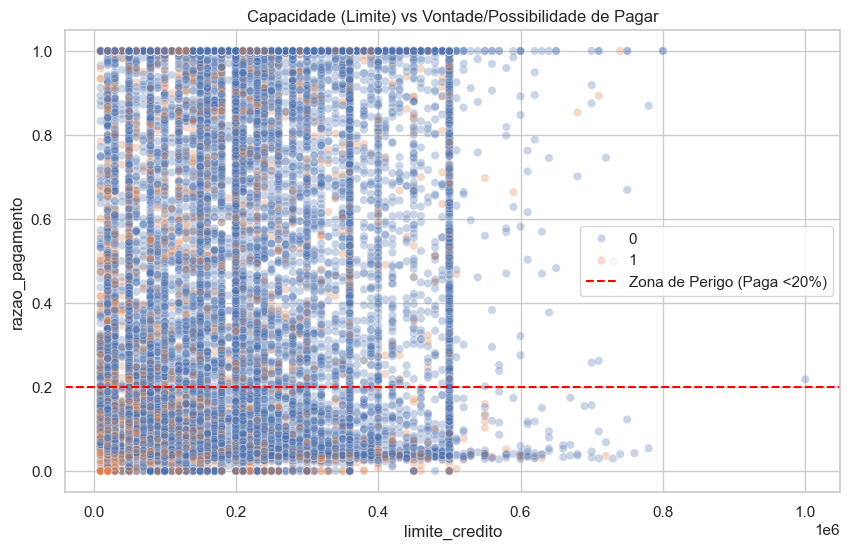

👉 INSIGHT: A nuvem de pontos mostra que inadimplência (laranja) concentra-se drasticamente abaixo da linha vermelha, independente do limite.


In [11]:
# Lógica: Limite > 200k E Razão Pagamento < 20% (paga o mínimo ou menos)
mask_rico_quebrado = (df_clean['limite_credito'] > 200000) & (df_clean['razao_pagamento'] < 0.2)

print(f"⚠️ Clientes 'Alto Limite / Baixo Pagamento': {mask_rico_quebrado.sum()}")

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='limite_credito', y='razao_pagamento', hue='is_inadimplente', alpha=0.3)
plt.axhline(0.2, color='red', linestyle='--', label='Zona de Perigo (Paga <20%)')
plt.title("Capacidade (Limite) vs Vontade/Possibilidade de Pagar")
plt.legend()
plt.show()

print("👉 INSIGHT: A nuvem de pontos mostra que inadimplência (laranja) concentra-se drasticamente abaixo da linha vermelha, independente do limite.")

#### P3: Atraso Crônico (O "Lost Cause"?)
*Business Value:* Já deve há meses. Ligar cobrando "educadamente" não funciona. Precisa de negociação/desconto.

In [12]:
# Lógica: Atraso > 0 em pelo menos 4 dos últimos 6 meses
mask_cronico = (df_clean[pay_cols] > 0).sum(axis=1) >= 4

print(f"💀 Clientes Crônicos: {mask_cronico.sum()}")

# Comparar taxa de default real (target) entre Crônicos vs O Resto
taxa_default_cronico = df_clean[mask_cronico]['is_inadimplente'].mean()
taxa_default_geral = df_clean[~mask_cronico]['is_inadimplente'].mean()

print(f"Probabilidade de Calote - Crônicos: {taxa_default_cronico:.1%}")
print(f"Probabilidade de Calote - Outros: {taxa_default_geral:.1%}")

print(f"👉 INSIGHT: Um cliente crônico tem {taxa_default_cronico/taxa_default_geral:.1f}x mais chance de dar calote. Segmentação deve isolar esse grupo imediatamente.")

💀 Clientes Crônicos: 2590
Probabilidade de Calote - Crônicos: 64.1%
Probabilidade de Calote - Outros: 18.0%
👉 INSIGHT: Um cliente crônico tem 3.6x mais chance de dar calote. Segmentação deve isolar esse grupo imediatamente.


### Passo 4: Conclusão para o Clustering
Quais variáveis realmente separam esses grupos?

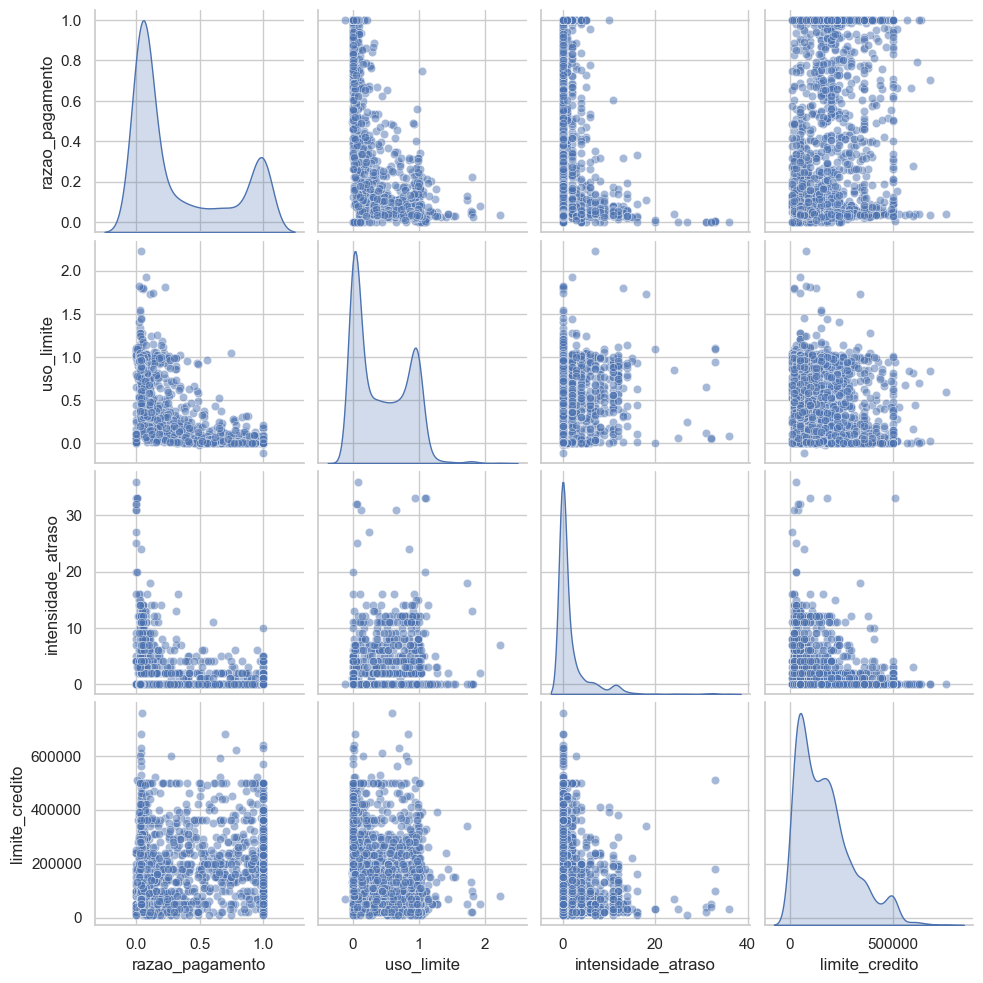

In [13]:
# Vamos plotar um Pairplot apenas com as features que criamos, colorindo pelo Target
cols_analise = ['razao_pagamento', 'uso_limite', 'intensidade_atraso', 'limite_credito']
sns.pairplot(df_clean[cols_analise].sample(2000), diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

### Passo 5: Geração da Base Silver
ATENÇÃO: Aqui descartamos as colunas de teste criadas durante o EDA ('intensidade_atraso', etc)
e usamos o pipeline oficial (src/features.py) para garantir que os nomes das colunas
sejam exatamete os que o modelo de Clustering espera ('score_gravidade', 'razao_pagamento_6m').

In [14]:
import sys
import os

# 1. GARANTIR QUE O SRC ESTÁ NO PATH (O pulo do gato para evitar o erro de import)
# Isso diz ao Python: "Olhe na pasta src que está um nível acima"
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(os.path.join(root_path, 'src'))

try:
    from features import process_pipeline
    print("✅ Módulo 'features' importado com sucesso.")
except ImportError:
    print("❌ ERRO: Não encontrei o arquivo 'src/features.py'. Verifique se o nome está correto.")

# 2. EXECUTAR O PIPELINE
# Caso você tenha renomeado o dataframe original, ajustamos aqui para df_clean
print("🔄 Gerando Schema oficial para o Clustering...")

# Usamos apenas colunas que não foram criadas manualmente no EDA para evitar conflitos
# Se df_raw não estiver na memória, o loader é chamado novamente
if 'df_raw' not in locals():
    from data_loader import load_raw_data
    file_path = os.path.join('..', 'data', 'raw', 'credit_card_clients.xls')
    df_raw = load_raw_data(file_path)

# Filtramos os ativos (conforme sua lógica de negócio no EDA)
pay_cols = [c for c in df_raw.columns if 'status_pag_' in c]
bill_cols = [c for c in df_raw.columns if 'bill_amt' in c]
filter_inativos = (df_raw[pay_cols].sum(axis=1) == -12) & (df_raw[bill_cols].sum(axis=1) == 0)
df_ativos = df_raw[~filter_inativos].copy()

# Aplica o processamento oficial do script src/features.py
df_silver_oficial = process_pipeline(df_ativos)

# 3. SALVAMENTO
output_path = os.path.join('..', 'data', 'processed', 'base_segmentacao_silver.csv')
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_silver_oficial.to_csv(output_path, index=False)

print(f"🚀 SUCESSO: Arquivo salvo em {output_path}")
print(f"Colunas para o modelo: {[c for c in df_silver_oficial.columns if 'score_gravidade' in c or 'razao_pagamento_6m' in c]}")

✅ Módulo 'features' importado com sucesso.
🔄 Gerando Schema oficial para o Clustering...
Tentando carregar: ..\data\raw\credit_card_clients.xls
✅ Arquivo detectado como Excel (.xls) e carregado com sucesso.
🚀 SUCESSO: Arquivo salvo em ..\data\processed\base_segmentacao_silver.csv
Colunas para o modelo: ['score_gravidade', 'razao_pagamento_6m']


**Decisão Final do EDA:**
1. **Filtro:** Precisamos remover ~10-15% de base inativa no pipeline final.
2. **Features:** `intensidade_atraso` e `razao_pagamento` são os maiores divisores de águas.
3. **Clusters Esperados:**
  - O "Tombo Recente" (Score atraso baixo, mas mês atual alto).
  - O "Alavancado" (Limite alto, uso alto, pagamento baixo).
  - O "Crônico" (Intensidade atraso altíssima).